In [ ]:
import os
import pickle
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import datetime
import cedne
import pywt
from tensorly.decomposition import parafac
from tensorly.decomposition import tucker
from tensorly.tenalg import multi_mode_dot
from tensorly import kruskal_to_tensor

In [2]:
today = str(datetime.datetime.now()).split(' ')[0]
outputDir = "Output/" + today + "/"
if not os.path.exists(outputDir):
    os.makedirs(outputDir)

num_timepoints = 450

In [ ]:
def wavelet_denoising(signal, wavelet='db4', level=4, threshold_factor=1.):
    coeffs = pywt.wavedec(signal, wavelet, mode='symmetric', level=level)
    
    # Estimate the universal threshold (Median Absolute Deviation)
    sigma = np.median(np.abs(coeffs[-level])) / 0.6745  
    threshold = threshold_factor * sigma * np.sqrt(2 * np.log(len(signal)))
    
    # Apply thresholding
    coeffs[1:] = [pywt.threshold(c, threshold, mode='soft') for c in coeffs[1:]]
    denoised_signal = pywt.waverec(coeffs, wavelet, mode='symmetric')
    
    return denoised_signal

def simpleaxis(axes, every=False, outward=False):
    if not isinstance(axes, (list, np.ndarray)):
        axes = [axes]
    for ax in axes:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        if (outward):
            ax.spines['bottom'].set_position(('outward', 10))
            ax.spines['left'].set_position(('outward', 10))
        if every:
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_title('')

def suffix_periods(periods):
    return [periods[0]+'-pre', periods[1], periods[2]+'-post']

def getCombinedName(name):
    if name[-1] in ['L', 'R'] and name not in ['RIR', 'ADL', 'AVL', 'OLL', 'ASEL', 'ASER']:
        return name[:-1]
    else:
        return name

def shuffle_axes(arr, axis='all'):
    shuffled_tensor = arr.copy()
    if isinstance(axis, int):
        # Get the dimensions of the tensor
        shape = shuffled_tensor.shape

        # Create a list of all axes except the specified one
        other_axes = list(range(shuffled_tensor.ndim))
        other_axes.remove(axis)

        # Iterate over all combinations of indices for the other axes
        for idx in np.ndindex(*[shape[i] for i in other_axes]):
            # Build a full index for the current slice
            full_idx = list(idx)
            full_idx.insert(axis, slice(None))
            full_idx = tuple(full_idx)

            # Shuffle along the specified axis for the current slice
            np.random.shuffle(shuffled_tensor[full_idx])

    elif isinstance(axis, str):
        if axis == 'all':
            # Flatten the array
            flat_arr = arr.ravel()
            # Shuffle the flattened array
            np.random.shuffle(flat_arr)
            # Reshape the array back to its original shape
            shuffled_tensor = flat_arr.reshape(arr.shape)
        elif axis == 'none':
            pass
    return shuffled_tensor

In [ ]:
pickleDir = 'pickles/2025-12-23/'
genotypes = ['N2', 'inx-7-mutant', 'inx-7-rescue']
promoters = ['ncs-1', 'inx-4', 'glr-1', 'acr-5', 'inx-4+mbr-1', 'flp-3p+flp-7p+nmr-1p+sro-1p', 'odr-2(2b)+odr-2(18)p']
stimuli = ['OP-PA-OP', 'OP-Buffer-OP', 'Buffer-PA-Buffer', 'Buffer-Buffer-Buffer', 'OP-gacA-OP']
conditions = ['naive', 'trained']

wormDict = { genotype:{
                    promoter:{
                        stimulus: {
                            condition: {} for condition in conditions
                        } for stimulus in stimuli
                    } for promoter in promoters
                } for genotype in genotypes 
            }

for pf in sorted(os.listdir(pickleDir)):
    print(pf)
    if not pf.startswith('.'):
        genotype, promoter, stimulus, condition, *name = pf.split('_')
        if not all ([genotype in genotypes, promoter in promoters, stimulus in stimuli, condition in conditions]):
            print(genotype in genotypes, promoter in promoters, stimulus in stimuli, condition in conditions, name)
        else:
            with open(pickleDir + pf, 'rb') as po:
                w = pickle.load(po)
                wormDict[genotype][promoter][stimulus][condition].update({w.name:w})

def clean_empty(d):
    """Recursively remove empty dicts from nested structure"""
    if isinstance(d, dict):
        # Recursively clean children
        cleaned = {k: clean_empty(v) for k, v in d.items()}
        # Filter out any keys whose values are empty dicts
        return {k: v for k, v in cleaned.items() if v != {}}
    else:
        return d  

# Clean your wormDict
wormDict = clean_empty(wormDict)

N2_acr-5_Buffer-Buffer-Buffer_naive_20240612-ZC3368-naive-buffer-buffer-30s-worm001
N2_acr-5_Buffer-Buffer-Buffer_naive_20240612-ZC3368-naive-buffer-buffer-30s-worm002
N2_acr-5_Buffer-Buffer-Buffer_naive_20240612-ZC3368-naive-buffer-buffer-30s-worm003
N2_acr-5_Buffer-Buffer-Buffer_naive_20240612-ZC3368-naive-buffer-buffer-30s-worm004
N2_acr-5_Buffer-Buffer-Buffer_naive_20240612-ZC3368-naive-buffer-buffer-30s-worm005
N2_acr-5_Buffer-Buffer-Buffer_naive_20240718-ZC3368-naive-buffer-buffer-30s-worm001
N2_acr-5_Buffer-Buffer-Buffer_naive_20240718-ZC3368-naive-buffer-buffer-30s-worm002
N2_acr-5_Buffer-Buffer-Buffer_naive_20240718-ZC3368-naive-buffer-buffer-30s-worm003
N2_acr-5_Buffer-Buffer-Buffer_naive_20240718-ZC3368-naive-buffer-buffer-30s-worm004
N2_acr-5_Buffer-Buffer-Buffer_naive_20240718-ZC3368-naive-buffer-buffer-30s-worm005
N2_acr-5_Buffer-Buffer-Buffer_trained_20240612-ZC3368-trained-buffer-buffer-30s-worm001
N2_acr-5_Buffer-Buffer-Buffer_trained_20240612-ZC3368-trained-buffer-buf

In [6]:
genotype_filter = genotypes
promoter_filter = promoters
stimulus_filter = stimuli#['Buffer-Buffer-Buffer']
condition_filter = conditions

n_per_cond={}
for genotype in wormDict:
    n_per_cond[genotype] = {}
    for promoter in wormDict[genotype]:
        if promoter in promoter_filter:
            n_per_cond[genotype][promoter] = {}
            for stimulus in wormDict[genotype][promoter]:
                if stimulus in stimulus_filter:
                    n_per_cond[genotype][promoter][stimulus] = {} 
                    for condition in wormDict[genotype][promoter][stimulus]:
                        if not condition in n_per_cond[genotype][promoter][stimulus]:
                            n_per_cond[genotype][promoter][stimulus][condition] = {}
                        for wname,w in wormDict[genotype][promoter][stimulus][condition].items():
                            n_per_cond[genotype][promoter][stimulus][condition][wname] = []
                            nn = w.networks[condition]
                            tn=[]
                            for n in nn.neurons:
                                m = getCombinedName(n)
                                if len(nn.neurons[n].trial):
                                        tn.append(m)
                            n_per_cond[genotype][promoter][stimulus][condition][wname]+=tn

In [7]:
# wormDict_copy = copy.deepcopy(wormDict)
wormDict_copy = wormDict

N2 ncs-1 OP-PA-OP
N2 ncs-1 OP-Buffer-OP
N2 ncs-1 Buffer-PA-Buffer
N2 ncs-1 Buffer-Buffer-Buffer
N2 ncs-1 OP-gacA-OP
5
0 dict_keys(['AFD', 'AWB', 'AWC', 'ASEL', 'ADF', 'ASH', 'BAG', 'OLL', 'AIY', 'SAAV', 'SAAD', 'AVK', 'ASG', 'ASI', 'AWA', 'ASER', 'RMG', 'ASK', 'ADL']) [34, 32, 34, 16, 20, 12, 34, 27, 6, 24, 16, 17, 31, 28, 26, 17, 7, 2, 2]
1 dict_keys(['ASG', 'ASI', 'AFD', 'AWA', 'AWB', 'AWC', 'ASEL', 'ASH', 'BAG', 'OLL', 'RMG', 'SAAV', 'AVK', 'ASK', 'ASER', 'ADF', 'ADL', 'AIY', 'SAAD', 'FLP']) [31, 22, 36, 27, 31, 38, 19, 14, 37, 28, 10, 27, 25, 2, 16, 20, 5, 5, 18, 1]
0 dict_keys(['ASG', 'ASI', 'AFD', 'AWA', 'AWB', 'AWC', 'ASEL', 'ASER', 'ADF', 'OLL', 'SAAV', 'ASH', 'BAG', 'RMG', 'AVK', 'SAAD']) [22, 9, 18, 18, 22, 25, 12, 12, 15, 11, 18, 4, 18, 2, 4, 3]
1 dict_keys(['ASG', 'ASI', 'AFD', 'AWA', 'AWB', 'AWC', 'BAG', 'OLL', 'SAAV', 'SAAD', 'ASK', 'ASEL', 'ASER', 'ADF', 'AVK', 'RMG', 'ASH', 'AIY']) [31, 15, 30, 17, 26, 30, 32, 21, 23, 10, 1, 12, 15, 16, 11, 7, 6, 2]
0 dict_keys(['ASK', 

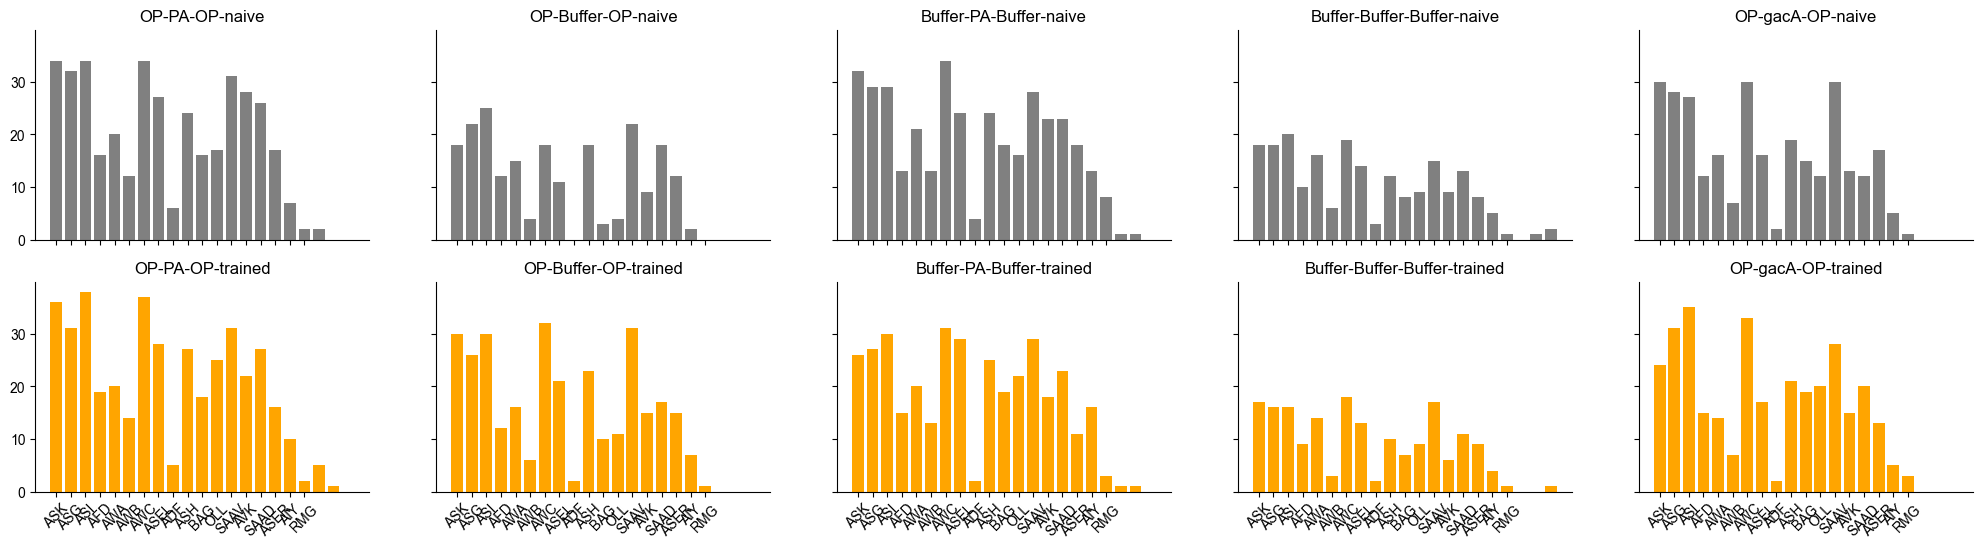

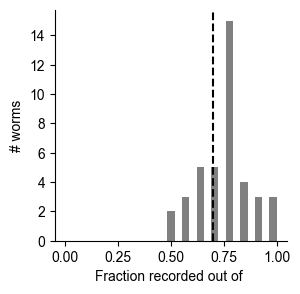

N2 inx-4 OP-PA-OP
N2 inx-4 Buffer-PA-Buffer
2
0 dict_keys(['FLP', 'OLL', 'AIN', 'ADA', 'RIG', 'RIM', 'ASG', 'ADF', 'ASH', 'BAG', 'AVJ', 'IL1']) [21, 21, 26, 28, 51, 27, 5, 1, 10, 2, 12, 1]
1 dict_keys(['FLP', 'AIN', 'ADA', 'RIG', 'RIM', 'AVJ', 'RIP', 'ASH', 'OLL', 'ASG', 'BAG', 'IL1', 'IL2']) [22, 28, 28, 53, 28, 10, 1, 6, 18, 4, 4, 2, 1]
0 dict_keys(['FLP', 'AIN', 'ADA', 'RIG', 'RIM', 'OLL', 'ASG', 'ASH', 'BAG', 'RIP', 'AFD', 'AWB', 'AWC', 'URX', 'RIR']) [14, 19, 20, 42, 21, 12, 6, 5, 2, 1, 1, 1, 1, 1, 4]
1 dict_keys(['FLP', 'AIN', 'ADA', 'RIG', 'RIM', 'OLL', 'BAG', 'ASG', 'ASH', 'AVJ', 'RIR']) [15, 21, 22, 44, 23, 15, 1, 4, 5, 3, 2]


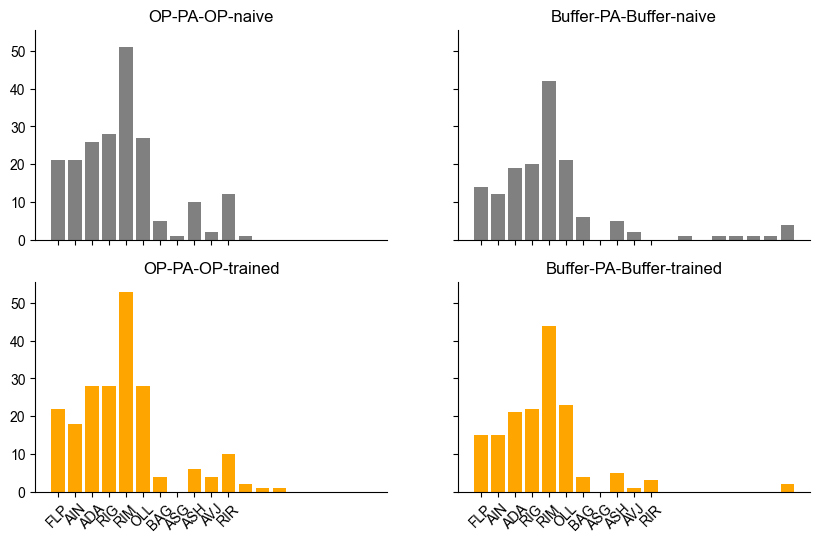

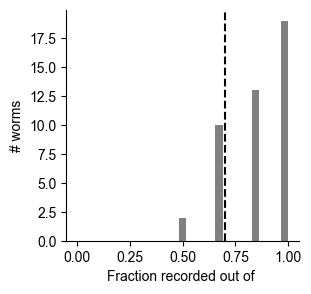

N2 glr-1 OP-PA-OP
N2 glr-1 Buffer-PA-Buffer
N2 glr-1 Buffer-Buffer-Buffer
3
0 dict_keys(['RIM', 'AVE', 'AVB', 'AVA', 'RMD', 'RMDV', 'AVD', 'RME', 'RMDD', 'SMDD', 'SMDV', 'RIA', 'RIS', 'M1']) [27, 25, 22, 27, 25, 27, 13, 18, 24, 24, 18, 7, 5, 6]
1 dict_keys(['RIM', 'AVE', 'AVA', 'RMDD', 'RMD', 'RMDV', 'SMDD', 'SMDV', 'RME', 'AVD', 'RIA', 'AVB', 'RIS', 'M1', 'AVJ']) [23, 21, 23, 23, 22, 23, 23, 16, 10, 14, 4, 19, 1, 5, 2]
0 dict_keys(['AVD', 'RIA', 'RIM', 'AVE', 'AVB', 'AVA', 'RMDD', 'RMD', 'RMDV', 'SMDD', 'SMDV', 'URYD', 'URYV', 'AIB', 'RME', 'M1']) [12, 6, 18, 18, 17, 20, 19, 18, 20, 18, 14, 1, 1, 1, 3, 1]
1 dict_keys(['AVD', 'RIM', 'AVE', 'AVB', 'AVA', 'RMDD', 'RMD', 'RMDV', 'SMDD', 'SMDV', 'AVJ', 'RME', 'URYD', 'URYV', 'M1', 'AIB', 'RIA']) [11, 25, 23, 22, 25, 24, 24, 27, 24, 23, 3, 11, 2, 2, 3, 3, 4]
0 dict_keys(['RIM', 'AVE', 'AVB', 'AVA', 'RMDD', 'RMDV', 'SMDD', 'SMDV', 'AVG', 'AIB', 'RIG', 'AVD', 'RIA', 'RME', 'RMD', 'M1', 'URYD', 'URYV', 'RIS']) [18, 17, 17, 17, 9, 16, 9, 15, 2,

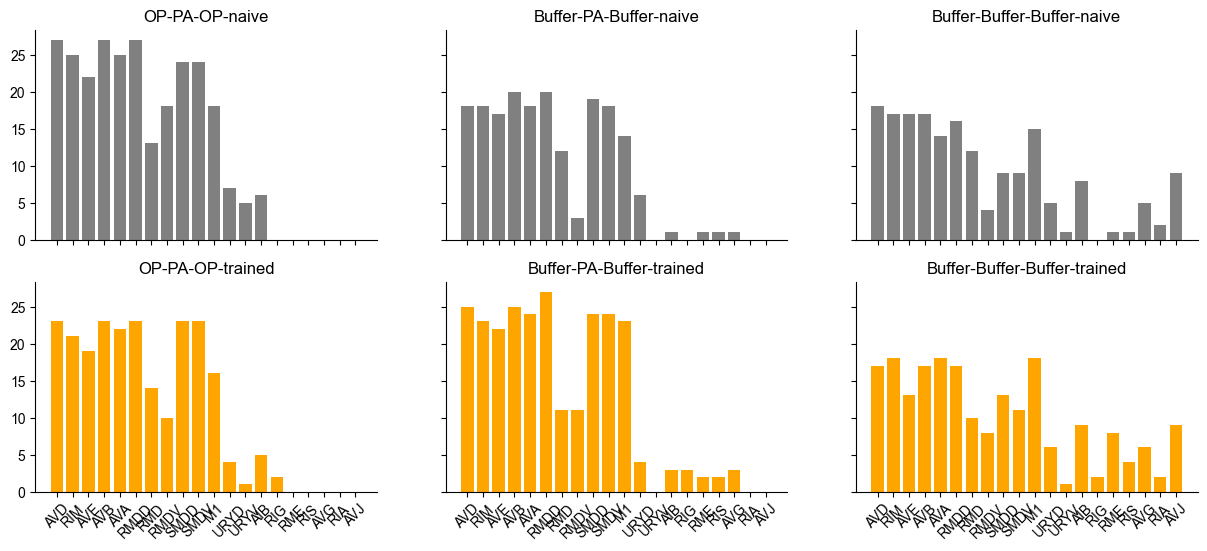

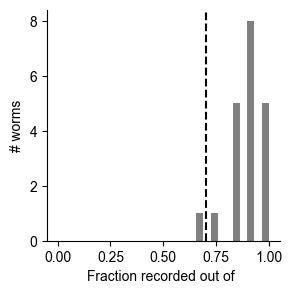

N2 acr-5 OP-PA-OP
N2 acr-5 Buffer-PA-Buffer
N2 acr-5 Buffer-Buffer-Buffer
3
0 dict_keys(['CEPD', 'URYD', 'URYV', 'OLL', 'ALA', 'RME', 'ASG', 'AVF', 'AVH', 'AVG', 'URAD', 'URAV', 'DB01', 'VB02', 'CEPV', 'AVD', 'VB01', 'DB02', 'ADA', 'SMDV', 'RMDV']) [16, 27, 24, 24, 22, 7, 13, 22, 6, 21, 25, 25, 13, 17, 22, 10, 16, 2, 2, 1, 1]
1 dict_keys(['URYD', 'URYV', 'OLL', 'RME', 'URAD', 'RMDV', 'CEPD', 'CEPV', 'ALA', 'AVF', 'AVG', 'URAV', 'VB01', 'VB02', 'ADA', 'AVD', 'ASG', 'AVH', 'DB01', 'SMDV', 'DB02']) [28, 27, 26, 12, 27, 5, 22, 24, 26, 31, 24, 26, 22, 25, 3, 9, 17, 6, 11, 1, 2]
0 dict_keys(['ASG', 'CEPD', 'CEPV', 'URYD', 'URYV', 'OLL', 'ALA', 'ADA', 'AVF', 'AVG', 'AVD', 'URAD', 'URAV', 'DB01', 'VB02', 'VB01', 'RME', 'AVH', 'SMDV', 'AIM']) [19, 20, 22, 27, 27, 25, 27, 13, 13, 17, 23, 25, 26, 14, 16, 9, 3, 4, 2, 1]
1 dict_keys(['ASG', 'CEPD', 'URYD', 'URYV', 'OLL', 'ADA', 'AVD', 'RME', 'URAD', 'URAV', 'CEPV', 'ALA', 'AVF', 'AVG', 'DB01', 'VB01', 'VB02', 'AIM', 'AVH', 'SMDV', 'RMDV']) [14, 23,

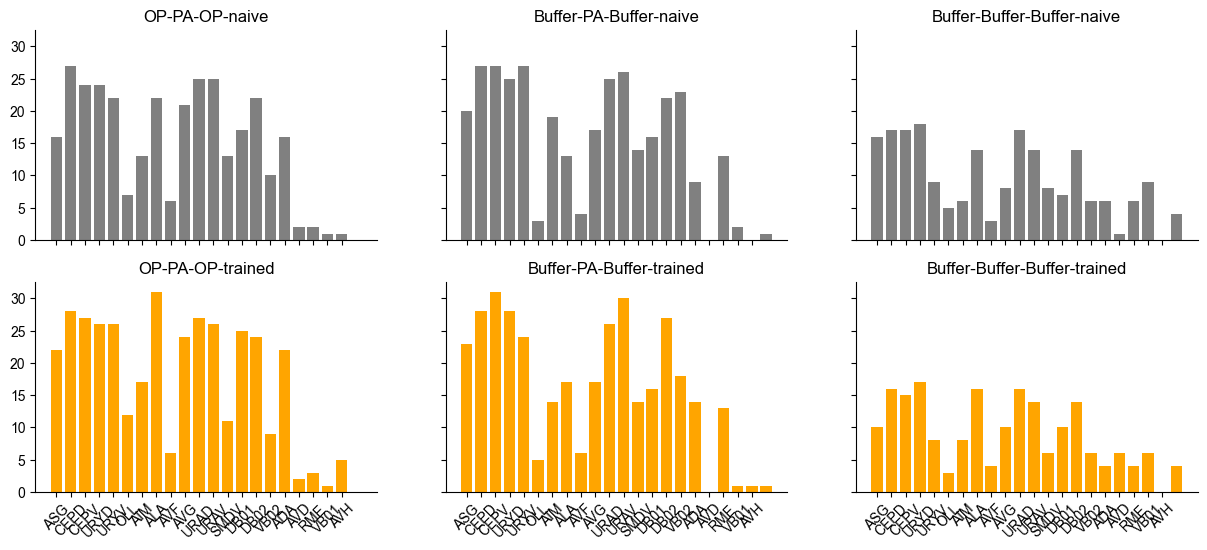

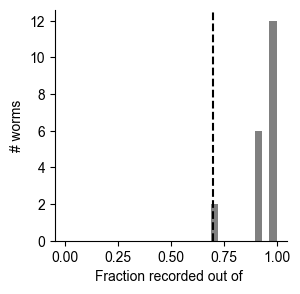

N2 inx-4+mbr-1 OP-PA-OP
N2 inx-4+mbr-1 Buffer-PA-Buffer
N2 inx-4+mbr-1 Buffer-Buffer-Buffer
3
0 dict_keys(['FLP', 'AIM', 'AIN', 'ADA', 'RIG', 'RIC', 'RIM', 'ASG', 'ASH', 'OLL', 'RIR', 'AVJ', 'IL1', 'BAG', 'RIP']) [24, 30, 35, 21, 42, 31, 39, 12, 6, 28, 14, 7, 5, 5, 6]
1 dict_keys(['FLP', 'OLL', 'AIM', 'ADA', 'RIG', 'RIC', 'AVJ', 'RIM', 'AIN', 'RIR', 'RIP', 'ASH', 'BAG', 'ASG', 'IL1']) [27, 32, 31, 27, 51, 33, 8, 42, 28, 13, 14, 6, 3, 5, 3]
0 dict_keys(['ASG', 'ADF', 'ASH', 'BAG', 'FLP', 'OLL', 'AIM', 'AIN', 'RIR', 'ADA', 'RIC', 'AVJ', 'RIM', 'RIP', 'RIG', 'AFD', 'RME']) [7, 2, 10, 3, 20, 17, 23, 22, 17, 20, 20, 12, 22, 10, 35, 2, 1]
1 dict_keys(['ASG', 'BAG', 'FLP', 'OLL', 'AIM', 'AIN', 'ADA', 'RIC', 'AVJ', 'RIM', 'RIP', 'RIG', 'ASH', 'RIR', 'ADE', 'RIH']) [10, 2, 25, 19, 24, 26, 26, 26, 13, 27, 12, 43, 15, 15, 1, 1]
0 dict_keys(['ASG', 'AFD', 'ASH', 'FLP', 'OLL', 'AIM', 'AIN', 'RIR', 'ADA', 'RIG', 'RIC', 'AVJ', 'RIM', 'URX', 'RIP', 'ADE']) [3, 1, 5, 17, 17, 14, 14, 7, 17, 19, 16, 7, 1

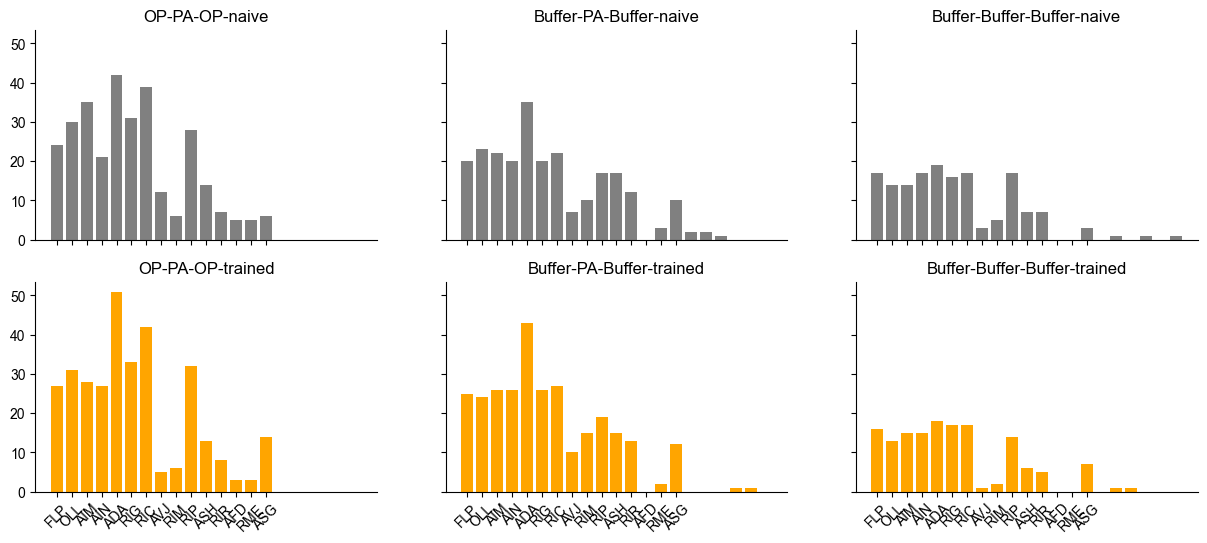

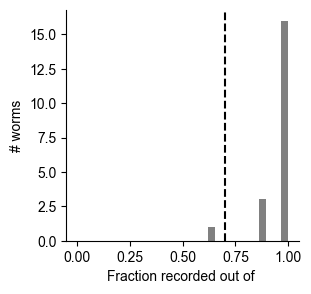

N2 flp-3p+flp-7p+nmr-1p+sro-1p OP-PA-OP
N2 flp-3p+flp-7p+nmr-1p+sro-1p Buffer-PA-Buffer
2
0 dict_keys(['IL1D', 'IL1', 'IL1V', 'AVG', 'SAAD', 'SAAV', 'AVD', 'RIM', 'AVE', 'AVA', 'SMDV', 'SIBV', 'ASI', 'AVF', 'ADL', 'SIBD']) [42, 38, 42, 21, 24, 37, 33, 35, 44, 42, 32, 36, 1, 29, 3, 5]
1 dict_keys(['ADL', 'IL1D', 'IL1', 'IL1V', 'AVF', 'AVG', 'SAAV', 'AVD', 'RIM', 'AVE', 'AVA', 'SMDV', 'SIBV', 'SAAD', 'SIBD']) [6, 38, 31, 37, 25, 17, 25, 28, 30, 32, 33, 26, 23, 13, 8]
0 dict_keys(['IL1D', 'IL1', 'IL1V', 'AVG', 'SAAV', 'AVD', 'RIM', 'AVE', 'AVA', 'SMDV', 'ASI', 'ADL', 'AVF', 'RME', 'SIBV', 'SAAD', 'SIBD']) [36, 34, 41, 22, 29, 26, 32, 36, 35, 26, 15, 7, 30, 13, 28, 11, 11]
1 dict_keys(['IL1D', 'IL1', 'IL1V', 'AVF', 'AVG', 'SAAD', 'SAAV', 'AVD', 'RIM', 'AVE', 'AVA', 'RME', 'SMDV', 'SIBV', 'ASI', 'ADL', 'SIBD']) [30, 24, 33, 25, 17, 15, 18, 22, 27, 30, 28, 11, 20, 21, 3, 3, 8]


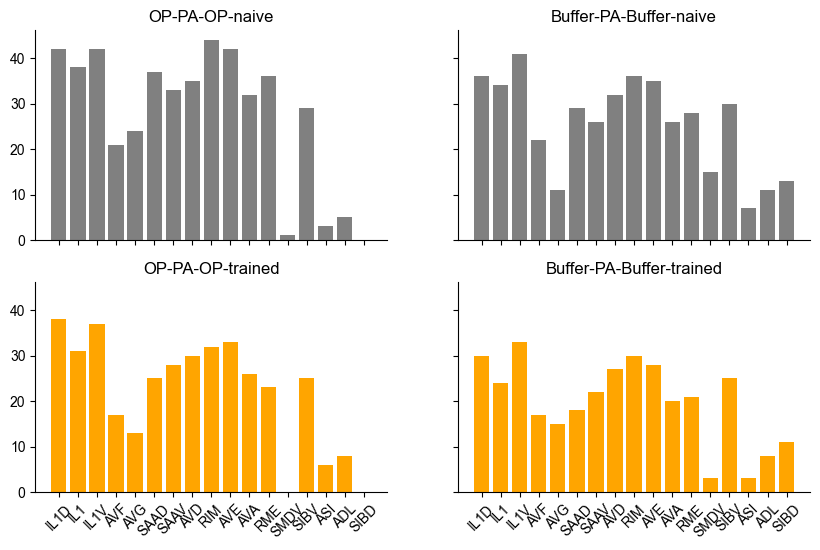

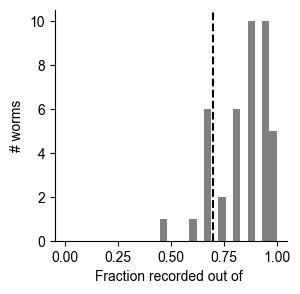

N2 odr-2(2b)+odr-2(18)p OP-PA-OP
N2 odr-2(2b)+odr-2(18)p Buffer-PA-Buffer
N2 odr-2(2b)+odr-2(18)p Buffer-Buffer-Buffer
3
0 dict_keys(['OLL', 'IL1D', 'IL1', 'AIZ', 'RIF', 'AVG', 'RME', 'SMBD', 'SMBV', 'SIAD', 'SIAV', 'ASG', 'IL1V', 'AIY', 'AIB', 'RMEV', 'RIV', 'RMED', 'IL2D', 'IL2', 'IL2V']) [33, 33, 36, 31, 34, 19, 36, 30, 35, 19, 29, 31, 32, 4, 37, 2, 20, 1, 1, 1, 1]
1 dict_keys(['ASG', 'OLL', 'IL1D', 'IL1', 'IL1V', 'AIZ', 'RIF', 'AVG', 'AIB', 'RME', 'RIV', 'SMBD', 'SMBV', 'SIAV', 'SIAD', 'AIY', 'RMED', 'RMEV', 'ADL', 'IL2D', 'IL2']) [29, 34, 31, 36, 33, 36, 27, 18, 35, 37, 26, 29, 33, 28, 11, 3, 1, 3, 1, 1, 2]
0 dict_keys(['ASG', 'IL1D', 'IL1', 'IL1V', 'AIZ', 'RIF', 'AVG', 'AIB', 'RME', 'SMBD', 'SMBV', 'SIAV', 'OLL', 'RIV', 'SIAD', 'AIY', 'ADL', 'RMEV', 'RMED']) [23, 34, 30, 39, 23, 45, 23, 31, 26, 36, 35, 33, 27, 18, 19, 6, 1, 2, 1]
1 dict_keys(['ASG', 'IL1D', 'IL1', 'IL1V', 'AIZ', 'RIF', 'AVG', 'AIB', 'RME', 'SMBD', 'SMBV', 'SIAV', 'OLL', 'RIV', 'SIAD', 'AIY']) [26, 30, 30, 38, 30,

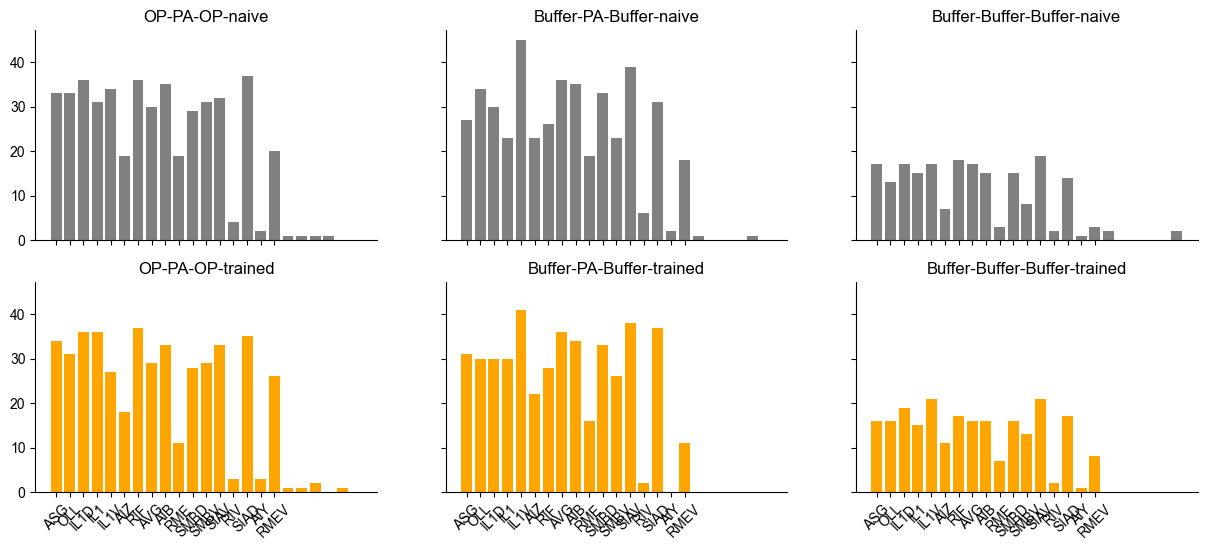

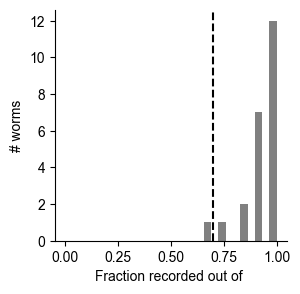

inx-7-mutant ncs-1 OP-PA-OP
1


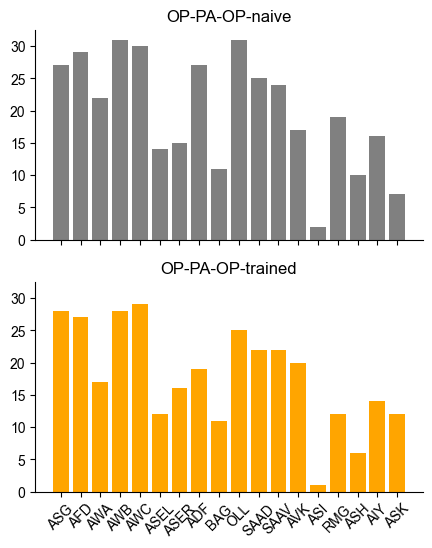

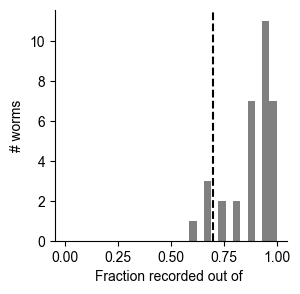

inx-7-rescue ncs-1 OP-PA-OP
1


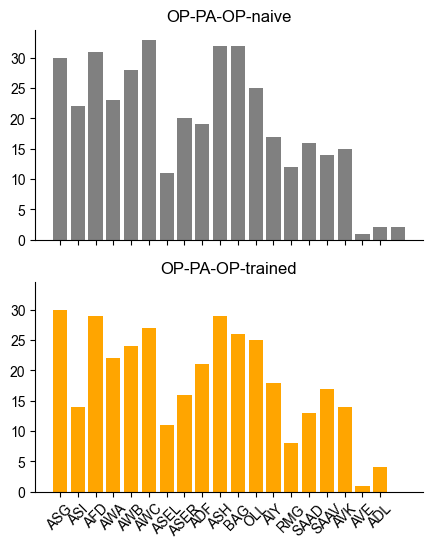

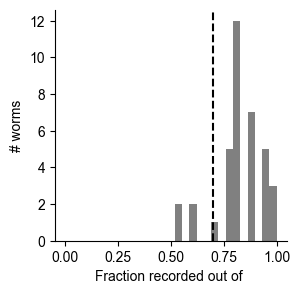

In [8]:
## Filtering neurons by minimum number of neurons necessary.

def filter_by_min_neurons(num_neurs_cond, min_neuron_num=8):
    all_neus_cond = {}
    total_neus_cond = {}
    all_neus = []
    for condition in num_neurs_cond: 
        if not condition in all_neus_cond:
            all_neus_cond[condition] = []
        for w,tn in num_neurs_cond[condition].items():
            all_neus+= tn
            all_neus_cond[condition]+=tn
        c = Counter(all_neus_cond[condition])
        total_neus_cond[condition] = c
        set_all_neus_cond = set(c.keys())
        for n in c:
            if c[n]<min_neuron_num:
                set_all_neus_cond.remove(n)
        all_neus_cond[condition] = set(set_all_neus_cond)

    all_neus_set = set(all_neus)
    for condition in all_neus_cond:
            all_neus_set = all_neus_set.intersection(all_neus_cond[condition])
    
    return all_neus_set, total_neus_cond


def plot_histogram_of_neurons(total_neus_cond):
    color_cond = ['gray', 'orange']
    print(len(total_neus_cond))
    f, ax = plt.subplots(nrows=2, ncols = len(total_neus_cond), figsize=(len(total_neus_cond)*5,6), sharex=True, sharey=True)
    for i,exp in enumerate(total_neus_cond):
        for j,cond in enumerate(total_neus_cond[exp]):
            if len(total_neus_cond)>1:
                neu_names = total_neus_cond[exp][cond].keys()
                print(j, neu_names, [total_neus_cond[exp][cond][n] for n in neu_names])
                ax[j,i].bar(neu_names, [total_neus_cond[exp][cond][n] for n in neu_names], color=color_cond[j])
                ax[j,i].set_xticks(range(len(total_neus_cond[exp][cond].keys())), neu_names , rotation=45)
                simpleaxis(ax[j,i])
                ax[j,i].set_title(f'{exp}-{cond}')
            else:
                neu_names = total_neus_cond[exp][cond].keys()
                ax[j].bar(neu_names, [total_neus_cond[exp][cond][n] for n in neu_names], color=color_cond[j])
                ax[j].set_xticks(range(len(total_neus_cond[exp][cond].keys())), neu_names, rotation=45)
                simpleaxis(ax[j])
                ax[j].set_title(f'{exp}-{cond}') 
    plt.show()

    bins = np.linspace(0,1,30)
    f, ax = plt.subplots(figsize=(3,3))
    ax.hist(frac, bins=bins, color='gray')
    ax.axvline(x=0.7, linestyle='--', color='k')
    simpleaxis(ax)
    ax.set_xlabel("Fraction recorded out of ")
    ax.set_ylabel("# worms")
    plt.show()

min_neuron_num = 8 # Minimum representation of a neuron
fracThreshold = 0.66 # Minimum neuron coverage for a given worm

all_neurs_set = {}
total_neurs_set = {}
for genotype in n_per_cond:
    all_neurs_set [genotype] = {}
    total_neurs_set[genotype] = {}
    for promoter in n_per_cond[genotype]:
        all_neurs_set [genotype][promoter] = {}
        total_neurs_set[genotype][promoter] = {}
        for stimulus in n_per_cond[genotype][promoter]:
            print(genotype, promoter, stimulus)
            all_neus_set, by_condition = filter_by_min_neurons(n_per_cond[genotype][promoter][stimulus], min_neuron_num)          
            if all(len(by_condition[cond]) for cond in by_condition):
                total_neurs_set[genotype][promoter][stimulus] = by_condition
            else:
                continue
            if len(all_neus_set):
                frac = []
                for condition in n_per_cond[genotype][promoter][stimulus]: 
                    for w,tn in n_per_cond[genotype][promoter][stimulus][condition].items():
                        frac.append(len(all_neus_set.intersection(set(tn)))/len(all_neus_set))
                        if frac[-1]<fracThreshold:
                            if w in wormDict_copy[genotype][promoter][stimulus][condition]: 
                                wormDict_copy[genotype][promoter][stimulus][condition].pop(w)
                all_neurs_set[genotype][promoter][stimulus] = sorted(list(all_neus_set))
        if len(total_neurs_set[genotype][promoter]):
            plot_histogram_of_neurons(total_neurs_set[genotype][promoter])

# Denoising the data

In [ ]:
## Denoising data

threshold_factor =  1.47 # Adjustable threshold factor
worm_neu_dict = {}
w_order = {}
worm_neu_dict_nodenoising = {}

for genotype in wormDict_copy:
    worm_neu_dict[genotype] = {}
    worm_neu_dict_nodenoising[genotype] = {}
    w_order[genotype] = {}
    for promoter in wormDict_copy[genotype]:
        worm_neu_dict[genotype][promoter] = {}
        worm_neu_dict_nodenoising[genotype][promoter] = {}
        w_order[genotype][promoter] = {}
        for stimulus in wormDict_copy[genotype][promoter]:
            worm_neu_dict[genotype][promoter][stimulus] = {}
            worm_neu_dict_nodenoising[genotype][promoter][stimulus] = {}
            w_order[genotype][promoter][stimulus] = {}
            if stimulus in all_neurs_set[genotype][promoter]:
                for cond in wormDict_copy[genotype][promoter][stimulus]:
                    if len(wormDict_copy[genotype][promoter][stimulus][cond]) > 0:
                        worm_neu_dict[genotype][promoter][stimulus][cond] = {}
                        worm_neu_dict_nodenoising[genotype][promoter][stimulus][cond] = {}
                        w_order[genotype][promoter][stimulus][cond] = []
                        if len(wormDict_copy[genotype][promoter][stimulus][cond].items()) and stimulus in all_neurs_set[genotype][promoter]:
                            for w_i, (w, worm) in enumerate(sorted(wormDict_copy[genotype][promoter][stimulus][cond].items(), key=lambda x: x[0])):
                                w_order[genotype][promoter][stimulus][cond].append(w)
                                worm_neu_dict[genotype][promoter][stimulus][cond][w] = {m:[] for m in all_neurs_set[genotype][promoter][stimulus]}
                                worm_neu_dict_nodenoising[genotype][promoter][stimulus][cond][w] = {m:[] for m in all_neurs_set[genotype][promoter][stimulus]}
                                for n in worm.networks[cond].neurons:
                                    m = getCombinedName(n)
                                    if len(worm.networks[cond].neurons[n].trial) and m in all_neurs_set[genotype][promoter][stimulus]:
                                        for trial in worm.networks[cond].neurons[n].trial:
                                            denoised_signal = wavelet_denoising(worm.networks[cond].neurons[n].trial[trial].recording, wavelet='db6', level=2, threshold_factor=threshold_factor)
                                            if np.isnan(denoised_signal).any():
                                                print("NaN in denoised signal", genotype, promoter, stimulus, cond, w, n, denoised_signal)
                                                continue
                                            worm_neu_dict[genotype][promoter][stimulus][cond][w][m].append(denoised_signal[:num_timepoints])
                                            worm_neu_dict_nodenoising[genotype][promoter][stimulus][cond][w][m].append( worm.networks[cond].neurons[n].trial[trial].recording[:num_timepoints])

NaN in denoised signal N2 ncs-1 Buffer-PA-Buffer naive ncs-1p 20221102 naive-worm2 AVKL [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan

In [ ]:
worm_tensors = {}
n_order = {}
for genotype in worm_neu_dict:
    worm_tensors[genotype] = {}
    n_order[genotype] = {}
    for promoter in worm_neu_dict[genotype]:
        worm_tensors[genotype][promoter] = {}
        n_order[genotype][promoter] = {}
        for stimulus in worm_neu_dict[genotype][promoter]:
            worm_tensors[genotype][promoter][stimulus] = {}
            n_order[genotype][promoter][stimulus] = {}
            for cond in worm_neu_dict[genotype][promoter][stimulus]:
                worm_tensors[genotype][promoter][stimulus][cond] = np.empty((len(all_neurs_set[genotype][promoter][stimulus]), num_timepoints, len(wormDict_copy[genotype][promoter][stimulus][cond])))
                worm_tensors[genotype][promoter][stimulus][cond].fill(np.nan)
                n_order[genotype][promoter][stimulus][cond] = {}
                if len(worm_neu_dict[genotype][promoter][stimulus][cond].items()):
                    for w_i, w in enumerate(worm_neu_dict[genotype][promoter][stimulus][cond]):
                        n_order[genotype][promoter][stimulus][cond][w] = []
                        for m in worm_neu_dict[genotype][promoter][stimulus][cond][w]:
                            if len(worm_neu_dict[genotype][promoter][stimulus][cond][w][m]) >1:
                                worm_tensors[genotype][promoter][stimulus][cond][all_neurs_set[genotype][promoter][stimulus].index(m),:,w_i] = np.nanmean(worm_neu_dict[genotype][promoter][stimulus][cond][w][m], axis=0)
                                n_order[genotype][promoter][stimulus][cond][w].append(m)
                            elif len(worm_neu_dict[genotype][promoter][stimulus][cond][w][m]) == 1:
                                worm_tensors[genotype][promoter][stimulus][cond][all_neurs_set[genotype][promoter][stimulus].index(m),:,w_i] = worm_neu_dict[genotype][promoter][stimulus][cond][w][m][0]
                                n_order[genotype][promoter][stimulus][cond][w].append(m)
                            else:
                                print("No data for", genotype, promoter, stimulus, cond, w, m, worm_neu_dict[genotype][promoter][stimulus][cond][w][m])


No data for N2 ncs-1 OP-PA-OP naive ncs-1p 20230330 naive-worm1 ASER []
No data for N2 ncs-1 OP-PA-OP naive ncs-1p 20230330 naive-worm1 ASG []
No data for N2 ncs-1 OP-PA-OP naive ncs-1p 20230330 naive-worm1 ASI []
No data for N2 ncs-1 OP-PA-OP naive ncs-1p 20230330 naive-worm1 AWA []
No data for N2 ncs-1 OP-PA-OP naive ncs-1p 20230330 naive-worm3 SAAD []
No data for N2 ncs-1 OP-PA-OP naive ncs-1p 20230330 naive-worm4 ADF []
No data for N2 ncs-1 OP-PA-OP naive ncs-1p 20230330 naive-worm4 ASH []
No data for N2 ncs-1 OP-PA-OP naive ncs-1p 20230330 naive-worm4 AWA []
No data for N2 ncs-1 OP-PA-OP naive ncs-1p 20230331 naive-worm1 ADF []
No data for N2 ncs-1 OP-PA-OP naive ncs-1p 20230331 naive-worm3 ASEL []
No data for N2 ncs-1 OP-PA-OP naive ncs-1p 20230331 naive-worm3 ASH []
No data for N2 ncs-1 OP-PA-OP naive ncs-1p 20230331 naive-worm3 AVK []
No data for N2 ncs-1 OP-PA-OP naive ncs-1p 20230331 naive-worm3 SAAD []
No data for N2 ncs-1 OP-PA-OP naive ncs-1p 20230331 naive-worm4 ADF []
No

In [ ]:
for genotype in worm_tensors:
    for promoter in worm_tensors[genotype]:
        for stimulus in worm_tensors[genotype][promoter]:
            for cond in worm_tensors[genotype][promoter][stimulus]:
                if np.isnan(worm_tensors[genotype][promoter][stimulus][cond]).all():
                    print("NaN in tensor", genotype, promoter, stimulus, cond)
                    print(np.shape(worm_tensors[genotype][promoter][stimulus][cond]))
                    continue
                for j in range(worm_tensors[genotype][promoter][stimulus][cond].shape[0]):
                    if np.isnan(worm_tensors[genotype][promoter][stimulus][cond][j]).all():
                        print("All NaN in tensor", genotype, promoter, stimulus, cond, all_neurs_set[genotype][promoter][stimulus][j])
                         

In [ ]:
## Initial imputation
worm_tensors_pre_imputed =  {}
for genotype in worm_tensors:
    worm_tensors_pre_imputed[genotype] = {}
    for promoter in worm_tensors[genotype]:
        worm_tensors_pre_imputed[genotype][promoter] = {}
        for stimulus in worm_tensors[genotype][promoter]:
            worm_tensors_pre_imputed[genotype][promoter][stimulus] = {}
            for cond in worm_tensors[genotype][promoter][stimulus]:
                worm_tensors_pre_imputed[genotype][promoter][stimulus][cond] = np.empty((len(all_neurs_set[genotype][promoter][stimulus]), num_timepoints, worm_tensors[genotype][promoter][stimulus][cond].shape[2]))
                worm_tensors_pre_imputed[genotype][promoter][stimulus][cond].fill(np.nan)
                for n in range(len(all_neurs_set[genotype][promoter][stimulus])):
                    for w in range(worm_tensors[genotype][promoter][stimulus][cond].shape[2]):
                        if not np.isnan(worm_tensors[genotype][promoter][stimulus][cond][n, :, w]).all():
                            worm_tensors_pre_imputed[genotype][promoter][stimulus][cond][n, :, w] = worm_tensors[genotype][promoter][stimulus][cond][n, :, w]
                        else:
                            # Calculate the mean activity of the same neuron from other worms
                            print("Is all nans", all_neurs_set[genotype][promoter][stimulus][n], np.isnan(worm_tensors[genotype][promoter][stimulus][cond][n, :, :]).all())
                            median_value = np.nanmedian(worm_tensors[genotype][promoter][stimulus][cond][n, :, :], axis=1)
                            worm_tensors_pre_imputed[genotype][promoter][stimulus][cond][n, :, w] = median_value

Is all nans ADF False
Is all nans ADF False
Is all nans ADF False
Is all nans ADF False
Is all nans ADF False
Is all nans ADF False
Is all nans ASEL False
Is all nans ASEL False
Is all nans ASEL False
Is all nans ASER False
Is all nans ASER False
Is all nans ASG False
Is all nans ASG False
Is all nans ASH False
Is all nans ASH False
Is all nans ASH False
Is all nans ASH False
Is all nans ASH False
Is all nans ASH False
Is all nans ASH False
Is all nans ASH False
Is all nans ASH False
Is all nans ASH False
Is all nans ASI False
Is all nans ASI False
Is all nans AVK False
Is all nans AVK False
Is all nans AWA False
Is all nans AWA False
Is all nans AWA False
Is all nans SAAD False
Is all nans SAAD False
Is all nans SAAD False
Is all nans ADF False
Is all nans ADF False
Is all nans ADF False
Is all nans ASEL False
Is all nans ASER False
Is all nans ASER False
Is all nans ASER False
Is all nans ASER False
Is all nans ASH False
Is all nans ASH False
Is all nans ASH False
Is all nans ASH Fal

In [ ]:
## imputation of missing neurons

# Extract the imputed data for each worm
rank = 10  # Choose the rank for the decomposition
worm_tensors_imputed = {}
full_imputed = {}
method = 'parafac'
for genotype in worm_tensors:
    worm_tensors_imputed[genotype] = {}
    for promoter in worm_tensors[genotype]:
        worm_tensors_imputed[genotype][promoter] = {}
        for stimulus in worm_tensors[genotype][promoter]:
            if len(worm_tensors[genotype][promoter][stimulus]):
                worm_tensors_imputed[genotype][promoter][stimulus] = {}
            else:
                continue
            for cond in worm_tensors[genotype][promoter][stimulus]:
                worm_tensors_imputed[genotype][promoter][stimulus][cond] = np.empty((len(all_neurs_set[genotype][promoter][stimulus]), num_timepoints, worm_tensors[genotype][promoter][stimulus][cond].shape[2]))
                worm_tensors_imputed[genotype][promoter][stimulus][cond].fill(np.nan)
                # Perform CP decomposition
                if method == 'parafac':
                    mask = ~np.isnan(worm_tensors[genotype][promoter][stimulus][cond])
                    print(genotype, promoter, stimulus, cond, np.shape(worm_tensors_pre_imputed[genotype][promoter][stimulus][cond]))
                    weights, factors = parafac(worm_tensors_pre_imputed[genotype][promoter][stimulus][cond], rank=rank, init='random', random_state=cedne.RANDOM_SEED, n_iter_max=100, mask=mask)
                    # Reconstruct the tensor with imputed values
                    imputed_tensor = kruskal_to_tensor((weights, factors))
                elif method == 'tucker':
                    weights, factors = tucker(worm_tensors_pre_imputed[genotype][promoter][stimulus][cond], rank=rank, init='random', random_state=cedne.RANDOM_SEED, n_iter_max=100)
                    # Reconstruct the tensor with imputed values
                    imputed_tensor = multi_mode_dot(weights, factors)
                    
                full_imputed[cond] = imputed_tensor

                for n in range(len(all_neurs_set[genotype][promoter][stimulus])):
                    for t in range(num_timepoints):
                        for w in range(worm_tensors[genotype][promoter][stimulus][cond].shape[2]):
                            if np.isnan(worm_tensors[genotype][promoter][stimulus][cond][n, t, w]):
                                worm_tensors_imputed[genotype][promoter][stimulus][cond][n, t, w] = imputed_tensor[n, t, w]
                            else:
                                worm_tensors_imputed[genotype][promoter][stimulus][cond][n, t, w] = worm_tensors[genotype][promoter][stimulus][cond][n, t, w]

N2 ncs-1 OP-PA-OP naive (15, 450, 19)
N2 ncs-1 OP-PA-OP trained (15, 450, 20)
N2 ncs-1 OP-Buffer-OP naive (12, 450, 14)
N2 ncs-1 OP-Buffer-OP trained (12, 450, 17)
N2 ncs-1 Buffer-PA-Buffer naive (16, 450, 20)
N2 ncs-1 Buffer-PA-Buffer trained (16, 450, 21)
N2 ncs-1 Buffer-Buffer-Buffer naive (12, 450, 10)
N2 ncs-1 Buffer-Buffer-Buffer trained (12, 450, 10)
N2 ncs-1 OP-gacA-OP naive (14, 450, 14)
N2 ncs-1 OP-gacA-OP trained (14, 450, 16)
N2 inx-4 OP-PA-OP naive (7, 450, 22)
N2 inx-4 OP-PA-OP trained (7, 450, 23)
N2 inx-4 Buffer-PA-Buffer naive (6, 450, 21)
N2 inx-4 Buffer-PA-Buffer trained (6, 450, 21)
N2 glr-1 OP-PA-OP naive (11, 450, 25)
N2 glr-1 OP-PA-OP trained (11, 450, 22)
N2 glr-1 Buffer-PA-Buffer naive (10, 450, 19)
N2 glr-1 Buffer-PA-Buffer trained (10, 450, 26)
N2 glr-1 Buffer-Buffer-Buffer naive (12, 450, 10)
N2 glr-1 Buffer-Buffer-Buffer trained (12, 450, 10)
N2 acr-5 OP-PA-OP naive (15, 450, 20)
N2 acr-5 OP-PA-OP trained (15, 450, 22)
N2 acr-5 Buffer-PA-Buffer naive (16, 4

In [ ]:
def block_to_df(genotype, promoter, stimulus, cond, arr, orig, all_neurs_set):
    if arr.ndim != 3:
        raise ValueError("Expected 3D ndarray")
    N, T, W = arr.shape

    # Worm-major, then neuron, then time: (W, N, T)
    vals = arr.transpose(2, 0, 1).reshape(-1)
    imputed_flag = np.isnan(orig).transpose(2, 0, 1).reshape(-1)

    w_idx = np.repeat(np.arange(W), N * T)
    n_idx = np.tile(np.repeat(np.arange(N), T), W)
    t_idx = np.tile(np.arange(T), N * W)

    names = np.asarray(all_neurs_set[genotype][promoter][stimulus])
    assert names.shape[0] == N

    return pd.DataFrame({
        "genotype": genotype,
        "promoter": promoter,
        "stimulus": stimulus,
        "condition": cond,
        "w": w_idx,
        "n": n_idx,
        "neuron": names[n_idx],
        "t": t_idx,
        "value": vals,
        "imputed": imputed_flag
    })

def save_worm_tensors_imputed_csv(worm_tensors_imputed, worm_tensors_original, all_neurs_set, out_csv):
    frames = []
    for genotype, d1 in worm_tensors_imputed.items():
        for promoter, d2 in d1.items():
            for stimulus, d3 in d2.items():
                for cond, arr in d3.items():
                    orig = worm_tensors_original[genotype][promoter][stimulus][cond]
                    frames.append(block_to_df(genotype, promoter, stimulus, cond, arr, orig, all_neurs_set))

    df = pd.concat(frames, ignore_index=True)
    df.to_csv(out_csv, index=False)
    return df

In [17]:
df_saved_imputed = save_worm_tensors_imputed_csv(worm_tensors_imputed, worm_tensors, all_neurs_set,"worm_tensors_imputed.csv")

In [ ]:
neuron = 'ADA'
condition = 'naive'
stimulus = 'OP-PA-OP'
# promoter = 'ncs-1'
imputed = False
genotype = 'N2'
val = df_saved_imputed[(df_saved_imputed['imputed']==imputed) & (df_saved_imputed['neuron']==neuron) & (df_saved_imputed['condition']==condition) & (df_saved_imputed['stimulus']==stimulus) & (df_saved_imputed['genotype']==genotype)] 

In [ ]:
## Save to pickle
with open (outputDir + 'worm_tensors.pickle', 'wb') as po:
    pickle.dump([all_neurs_set, worm_tensors, worm_tensors_imputed], po)

In [23]:
for genotype in worm_tensors_imputed:
    for promoter in worm_tensors_imputed[genotype]:
        for stim in worm_tensors_imputed[genotype][promoter]:
            for cond in worm_tensors_imputed[genotype][promoter][stim]:
                arr = worm_tensors_imputed[genotype][promoter][stim][cond]
                for trial in arr:
                    if np.isnan(trial).any():
                        print("NaN found in {genotype} [{promoter}][{stim}][{cond}] trial")                


In [23]:
def build_common_by_promoter(genotypes, all_neurs_set, promoter):
    name_lists = []
    for g in genotypes:
        for stim, lst in all_neurs_set.get(g, {}).get(promoter, {}).items():
            name_lists.append(lst)  # ordered list
    if not name_lists:
        return []
    inter = set(name_lists[0]).intersection(*map(set, name_lists[1:]))
    return [n for n in name_lists[0] if n in inter]  # deterministic order

all_neurs_set_common_across_promoters = {}
common_neurs = {}

for g in genotypes:
    all_neurs_set_common_across_promoters[g] = {}
    for promoter in worm_tensors_imputed.get(g, {}):
        if promoter not in common_neurs:
            common_neurs[promoter] = build_common_by_promoter(genotypes, all_neurs_set, promoter)
        if not common_neurs[promoter]:
            continue

        all_neurs_set_common_across_promoters[g][promoter] = {}
        for stimulus, cond_dict in worm_tensors_imputed[g][promoter].items():
            names_src = all_neurs_set[g][promoter][stimulus]              # ordered source names
            idx_map   = {n:i for i,n in enumerate(names_src)}
            gather    = [idx_map[n] for n in common_neurs[promoter] if n in idx_map]

            all_neurs_set_common_across_promoters[g][promoter][stimulus] = {}
            for cond, arr in cond_dict.items():                            # arr: (N_src, T, W)
                T, W = arr.shape[1], arr.shape[2]
                out = arr[gather, :, :]                                    # gather by names
                all_neurs_set_common_across_promoters[g][promoter][stimulus][cond] = out

with open(outputDir + 'worm_tensors_common_neurs.pickle', 'wb') as po:
    pickle.dump([common_neurs, all_neurs_set_common_across_promoters], po)